In [1]:
#!/usr/bin/python -u
! pip install pydicom
! pip install python-gdcm
! pip install -U pylibjpeg pylibjpeg-openjpeg pylibjpeg-libjpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 74.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 65.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import pydicom

In [19]:
def correct_dcm(dcm):
    # Corrects the DICOM pixel values by adding 1000 to each value
    x = dcm.pixel_array + 1000
    px_mode = 4096
    # Adjusts pixel values greater than or equal to 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    # Converts the corrected pixel array back to bytes and assigns it to PixelData
    dcm.PixelData = x.to_bytes()
    # Sets the RescaleIntercept value to -1000
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    # Checks if the DICOM has 12 bits, unsigned representation, and RescaleIntercept > -100
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        # Corrects the DICOM if the conditions are met
        correct_dcm(dcm)

    # Applies windowing to the DICOM image
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    # Clips the pixel values within the specified window range
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):
    # Applies windowing to different regions of the brain in the DICOM image
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 30, 30)

    # Normalizes the pixel values in each window range
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - 15) / 30

    # Combines the normalized images into a single array
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img


def _read(img, desired_size):
    """Will be used in DataGenerator"""
    # Reads the DICOM image using pydicom
    dcm = pydicom.dcmread(img)
    # Replaces specific pixel values (30768) with -2000
    dcm.pixel_array[dcm.pixel_array == 30768] = -2000
    # Applies windowing to the DICOM image
    img = bsb_window(dcm)

    # Resizes the image to the desired size using OpenCV
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)

    return img

In [20]:
img = _read('/examples/ID_000012eaf.dcm', (512, 512))

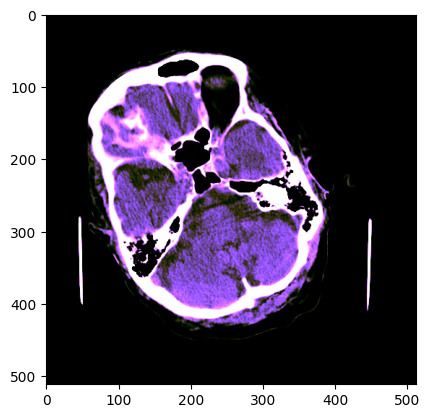

In [22]:
plt.imshow(img)